# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
from torchsummary import summary


In [2]:
from google.colab import files
# uploaded = files.upload()

In [ ]:
import model
from model import Net

# model params for 3 normalization techniques

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalization_type="group").to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              45
         GroupNorm-2            [-1, 5, 26, 26]              10
              ReLU-3            [-1, 5, 26, 26]               0
         Dropout2d-4            [-1, 5, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             450
         GroupNorm-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
         Dropout2d-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           1,350
        GroupNorm-11           [-1, 15, 10, 10]              30
             ReLU-12           [-1, 15, 10, 10]               0
        Dropout2d-13           [-1, 15, 10, 10]               0
           Conv2d-14             [

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalization_type="layer").to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              45
         GroupNorm-2            [-1, 5, 26, 26]              10
              ReLU-3            [-1, 5, 26, 26]               0
         Dropout2d-4            [-1, 5, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             450
         GroupNorm-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
         Dropout2d-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           1,350
        GroupNorm-11           [-1, 15, 10, 10]              30
             ReLU-12           [-1, 15, 10, 10]               0
        Dropout2d-13           [-1, 15, 10, 10]               0
           Conv2d-14             [

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalization_type="batch").to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              45
       BatchNorm2d-2            [-1, 5, 26, 26]              10
              ReLU-3            [-1, 5, 26, 26]               0
         Dropout2d-4            [-1, 5, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             450
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
         Dropout2d-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           1,350
      BatchNorm2d-11           [-1, 15, 10, 10]              30
             ReLU-12           [-1, 15, 10, 10]               0
        Dropout2d-13           [-1, 15, 10, 10]               0
           Conv2d-14             [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [15]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                    #    transforms.ToPILImage(),
                                       transforms.RandomRotation((-7.5, 7.5), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [16]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [18]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(2.8017)
 - std: tensor(0.2500)
 - var: tensor(0.0625)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


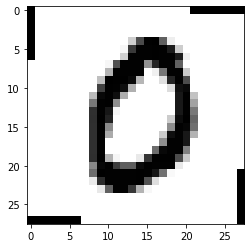

In [19]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

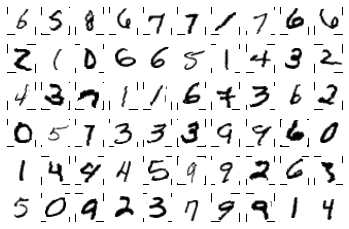

In [20]:




figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [21]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,flag):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # train_losses.append(loss)
    # loss =  F.mse_loss(y_pred, target)
    if flag==True:
        # l1 = 0
        l1 = 0            
        for W in model.parameters():
            l1 = l1+W.abs().sum()
        loss = loss + lambda_l1 *l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Misclassify Images

In [22]:
import matplotlib.pyplot as plt
def find_misclassified(test_loader, device):
        misclassified = []
        misclassified_prediction = []
        misclassified_target = []
        i=0
        # put the model to evaluation mode
        model.eval()
        # turn off gradients
        with torch.no_grad():
            for data, target in test_loader:
                # move them to the respective device
                data, target = data.to(device), target.to(device)
                # do inferencing
                output = model(data)
                # get the predicted output
                pred = output.argmax(dim=1, keepdim=True)

                # get the current misclassified in this batch
                list_misclassified = (pred.eq(target.view_as(pred)) == False)
                batch_misclassified = data[list_misclassified]
                batch_mis_prediction = pred[list_misclassified]
                batch_mis_target = target.view_as(pred)[list_misclassified]

                # batch_misclassified

                misclassified.append(batch_misclassified)
                misclassified_prediction.append(batch_mis_prediction)
                misclassified_target.append(batch_mis_target)
                i =i+1
                if i>=10:
                    break

        # group all the batched together
        misclassified = torch.cat(misclassified)
        misclassified_pred = torch.cat(misclassified_prediction)
        misclassified_target = torch.cat(misclassified_target)
        ncols=5
        image_data, predicted, actual=misclassified, misclassified_pred, misclassified_target
        fig, ax = plt.subplots(2,5,figsize=(8, 4))
        for i in range(2):
            for j in range(5):
                index = i * ncols + j 
                ax[i, j].axis("off")
                ax[i, j].set_title("  Predicted: %d\nActual: %d" % (predicted[index], actual[index]))
                ax[i, j].imshow(image_data[index].cpu().numpy(), cmap="gray_r")


# find_misclassified(test_loader, device)

# Train and Test Our Model

In [23]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

# will be used while plotting graphs
lambda_l1 =0.001
train_losses = []
test_losses = []
train_acc = []
test_acc = []

training_losses_group = []
testing_losses_group = []
training_accuracy_group = []
testing_accuracy_group = []

print(" B norm")
model = Net(normalization_type="batch").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 21):
    print("EPOCH:", epoch)#, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch,flag=True)
    test(model, device, test_loader)
    #scheduler.step()
b_train_losses = train_losses
b_test_losses = test_losses 
b_train_acc = train_acc
b_test_acc = test_acc


 B norm
EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.49393850564956665 Batch_id=468 Accuracy=78.44: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]



Test set: Average loss: 0.1642, Accuracy: 9635/10000 (96.35%)

EPOCH: 2


Loss=0.3897534906864166 Batch_id=468 Accuracy=95.61: 100%|██████████| 469/469 [00:45<00:00, 10.32it/s]



Test set: Average loss: 0.1179, Accuracy: 9696/10000 (96.96%)

EPOCH: 3


Loss=0.3887191712856293 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]



Test set: Average loss: 0.0942, Accuracy: 9749/10000 (97.49%)

EPOCH: 4


Loss=0.4366316795349121 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]



Test set: Average loss: 0.0730, Accuracy: 9817/10000 (98.17%)

EPOCH: 5


Loss=0.32566455006599426 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:45<00:00, 10.23it/s]



Test set: Average loss: 0.0938, Accuracy: 9732/10000 (97.32%)

EPOCH: 6


Loss=0.35982513427734375 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]



Test set: Average loss: 0.0835, Accuracy: 9761/10000 (97.61%)

EPOCH: 7


Loss=0.3300616145133972 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]



Test set: Average loss: 0.0811, Accuracy: 9767/10000 (97.67%)

EPOCH: 8


Loss=0.31546032428741455 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:46<00:00, 10.17it/s]



Test set: Average loss: 0.0591, Accuracy: 9845/10000 (98.45%)

EPOCH: 9


Loss=0.33088552951812744 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:46<00:00, 10.02it/s]



Test set: Average loss: 0.0682, Accuracy: 9811/10000 (98.11%)

EPOCH: 10


Loss=0.27684834599494934 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]



Test set: Average loss: 0.0993, Accuracy: 9702/10000 (97.02%)

EPOCH: 11


Loss=0.4554491341114044 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:46<00:00, 10.02it/s]



Test set: Average loss: 0.0574, Accuracy: 9843/10000 (98.43%)

EPOCH: 12


Loss=0.3592047393321991 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:46<00:00, 10.04it/s]



Test set: Average loss: 0.0683, Accuracy: 9805/10000 (98.05%)

EPOCH: 13


Loss=0.27085837721824646 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0662, Accuracy: 9826/10000 (98.26%)

EPOCH: 14


Loss=0.28974324464797974 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s]



Test set: Average loss: 0.0516, Accuracy: 9860/10000 (98.60%)

EPOCH: 15


Loss=0.3693734407424927 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.0927, Accuracy: 9719/10000 (97.19%)

EPOCH: 16


Loss=0.357777863740921 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s]



Test set: Average loss: 0.0632, Accuracy: 9841/10000 (98.41%)

EPOCH: 17


Loss=0.39878010749816895 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0599, Accuracy: 9838/10000 (98.38%)

EPOCH: 18


Loss=0.31476330757141113 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:46<00:00, 10.14it/s]



Test set: Average loss: 0.0599, Accuracy: 9823/10000 (98.23%)

EPOCH: 19


Loss=0.27553966641426086 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]



Test set: Average loss: 0.0558, Accuracy: 9857/10000 (98.57%)

EPOCH: 20


Loss=0.29865676164627075 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]



Test set: Average loss: 0.0658, Accuracy: 9826/10000 (98.26%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


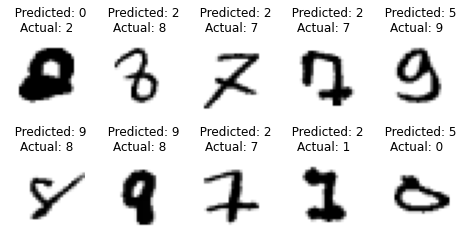

In [24]:

find_misclassified(test_loader, device)

In [25]:
model = Net(normalization_type="layer").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1, 21):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch,flag=False)
    test(model, device, test_loader)
    scheduler.step()
l_train_losses = train_losses
l_test_losses = test_losses 
l_train_acc = train_acc
l_test_acc = test_acc


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


EPOCH: 1 LR =  [0.01]


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.3076143264770508 Batch_id=468 Accuracy=70.99: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s]



Test set: Average loss: 0.2304, Accuracy: 9383/10000 (93.83%)

EPOCH: 2 LR =  [0.01]


Loss=0.11485055088996887 Batch_id=468 Accuracy=94.58: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]



Test set: Average loss: 0.0841, Accuracy: 9779/10000 (97.79%)

EPOCH: 3 LR =  [0.01]


Loss=0.11544975638389587 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s]



Test set: Average loss: 0.0582, Accuracy: 9846/10000 (98.46%)

EPOCH: 4 LR =  [0.01]


Loss=0.15127380192279816 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:45<00:00, 10.37it/s]



Test set: Average loss: 0.0480, Accuracy: 9871/10000 (98.71%)

EPOCH: 5 LR =  [0.01]


Loss=0.062289755791425705 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]



Test set: Average loss: 0.0429, Accuracy: 9884/10000 (98.84%)

EPOCH: 6 LR =  [0.01]


Loss=0.09280190616846085 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:44<00:00, 10.46it/s]



Test set: Average loss: 0.0375, Accuracy: 9900/10000 (99.00%)

EPOCH: 7 LR =  [0.0001]


Loss=0.08469714969396591 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:45<00:00, 10.42it/s]



Test set: Average loss: 0.0316, Accuracy: 9910/10000 (99.10%)

EPOCH: 8 LR =  [0.001]


Loss=0.04966595768928528 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]



Test set: Average loss: 0.0300, Accuracy: 9919/10000 (99.19%)

EPOCH: 9 LR =  [0.001]


Loss=0.11012064665555954 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:45<00:00, 10.38it/s]



Test set: Average loss: 0.0298, Accuracy: 9910/10000 (99.10%)

EPOCH: 10 LR =  [0.001]


Loss=0.029375026002526283 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:44<00:00, 10.46it/s]



Test set: Average loss: 0.0295, Accuracy: 9914/10000 (99.14%)

EPOCH: 11 LR =  [0.001]


Loss=0.062483981251716614 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]



Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

EPOCH: 12 LR =  [0.001]


Loss=0.027532391250133514 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s]



Test set: Average loss: 0.0299, Accuracy: 9914/10000 (99.14%)

EPOCH: 13 LR =  [1e-05]


Loss=0.04547085240483284 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:44<00:00, 10.46it/s]



Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)

EPOCH: 14 LR =  [0.0001]


Loss=0.0925261378288269 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s]



Test set: Average loss: 0.0288, Accuracy: 9917/10000 (99.17%)

EPOCH: 15 LR =  [0.0001]


Loss=0.07782144099473953 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:44<00:00, 10.49it/s]



Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

EPOCH: 16 LR =  [0.0001]


Loss=0.04032158479094505 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s]



Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

EPOCH: 17 LR =  [0.0001]


Loss=0.04013137146830559 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s]



Test set: Average loss: 0.0287, Accuracy: 9917/10000 (99.17%)

EPOCH: 18 LR =  [0.0001]


Loss=0.06344743818044662 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s]



Test set: Average loss: 0.0283, Accuracy: 9918/10000 (99.18%)

EPOCH: 19 LR =  [1.0000000000000002e-06]


Loss=0.033571574836969376 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:44<00:00, 10.47it/s]



Test set: Average loss: 0.0283, Accuracy: 9918/10000 (99.18%)

EPOCH: 20 LR =  [1e-05]


Loss=0.10955553501844406 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]



Test set: Average loss: 0.0283, Accuracy: 9919/10000 (99.19%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


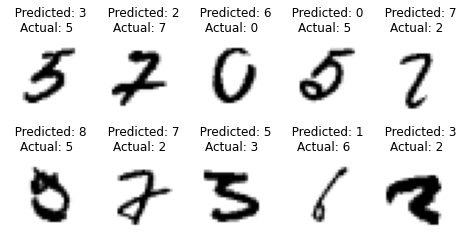

In [ ]:
find_misclassified(test_loader, device)

In [27]:
model = Net(normalization_type="group").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1, 21):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch,flag=False)
    test(model, device, test_loader)
    scheduler.step()
g_train_losses = train_losses
g_test_losses = test_losses 
g_train_acc = train_acc
g_test_acc = test_acc


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


EPOCH: 1 LR =  [0.01]


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.2158898264169693 Batch_id=468 Accuracy=72.23: 100%|██████████| 469/469 [00:44<00:00, 10.56it/s]



Test set: Average loss: 0.1704, Accuracy: 9604/10000 (96.04%)

EPOCH: 2 LR =  [0.01]


Loss=0.09134111553430557 Batch_id=468 Accuracy=95.09: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]



Test set: Average loss: 0.0838, Accuracy: 9776/10000 (97.76%)

EPOCH: 3 LR =  [0.01]


Loss=0.12416812777519226 Batch_id=468 Accuracy=96.45: 100%|██████████| 469/469 [00:45<00:00, 10.40it/s]



Test set: Average loss: 0.0519, Accuracy: 9868/10000 (98.68%)

EPOCH: 4 LR =  [0.01]


Loss=0.12293597310781479 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:44<00:00, 10.51it/s]



Test set: Average loss: 0.0465, Accuracy: 9852/10000 (98.52%)

EPOCH: 5 LR =  [0.01]


Loss=0.028819376602768898 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:44<00:00, 10.49it/s]



Test set: Average loss: 0.0507, Accuracy: 9845/10000 (98.45%)

EPOCH: 6 LR =  [0.01]


Loss=0.05665485933423042 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:44<00:00, 10.51it/s]



Test set: Average loss: 0.0445, Accuracy: 9869/10000 (98.69%)

EPOCH: 7 LR =  [0.0001]


Loss=0.02706238068640232 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]



Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)

EPOCH: 8 LR =  [0.001]


Loss=0.0728679820895195 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:44<00:00, 10.49it/s]



Test set: Average loss: 0.0299, Accuracy: 9900/10000 (99.00%)

EPOCH: 9 LR =  [0.001]


Loss=0.05963228642940521 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s]



Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH: 10 LR =  [0.001]


Loss=0.17765964567661285 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:44<00:00, 10.44it/s]



Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.13%)

EPOCH: 11 LR =  [0.001]


Loss=0.054789599031209946 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:44<00:00, 10.56it/s]



Test set: Average loss: 0.0293, Accuracy: 9904/10000 (99.04%)

EPOCH: 12 LR =  [0.001]


Loss=0.1485780030488968 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s]



Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

EPOCH: 13 LR =  [1e-05]


Loss=0.07353969663381577 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]



Test set: Average loss: 0.0277, Accuracy: 9912/10000 (99.12%)

EPOCH: 14 LR =  [0.0001]


Loss=0.13046301901340485 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:44<00:00, 10.55it/s]



Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

EPOCH: 15 LR =  [0.0001]


Loss=0.04755645617842674 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:44<00:00, 10.60it/s]



Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 16 LR =  [0.0001]


Loss=0.07298553735017776 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s]



Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

EPOCH: 17 LR =  [0.0001]


Loss=0.06417609751224518 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:44<00:00, 10.42it/s]



Test set: Average loss: 0.0273, Accuracy: 9914/10000 (99.14%)

EPOCH: 18 LR =  [0.0001]


Loss=0.08504924178123474 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:44<00:00, 10.49it/s]



Test set: Average loss: 0.0272, Accuracy: 9919/10000 (99.19%)

EPOCH: 19 LR =  [1.0000000000000002e-06]


Loss=0.07759559899568558 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:44<00:00, 10.51it/s]



Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.17%)

EPOCH: 20 LR =  [1e-05]


Loss=0.0328122042119503 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]



Test set: Average loss: 0.0273, Accuracy: 9918/10000 (99.18%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


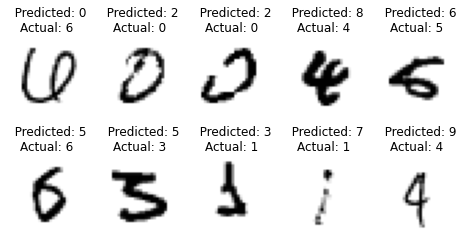

In [28]:
find_misclassified(test_loader, device)

# Test and Train Accuracy and loss graphs

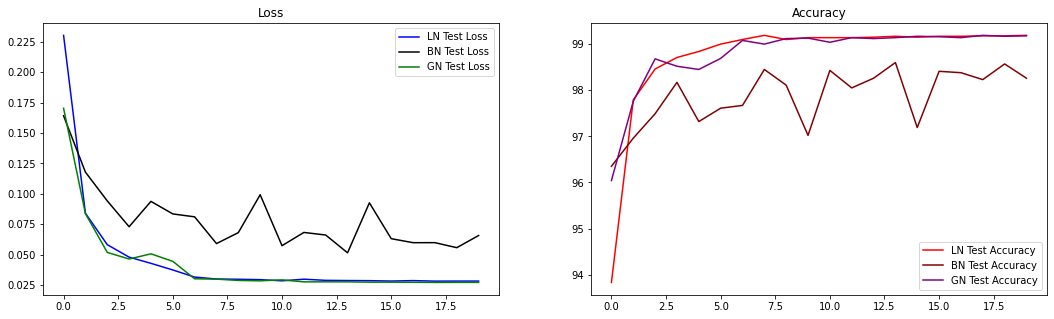

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
ax1 = ax[0]
ax1.set_title("Loss")
ax1.plot(l_test_losses, color="blue", label="LN Test Loss")
ax1.plot(b_test_losses, color="black", label="BN Test Loss")
ax1.plot(g_test_losses,color="green", label="GN Test Loss")
ax1.legend()
ax2 = ax[1]
ax2.set_title("Accuracy")
ax2.plot(l_test_acc, color="red", label="LN Test Accuracy")
ax2.plot(b_test_acc, color="maroon", label="BN Test Accuracy")
ax2.plot(g_test_acc, color="purple", label="GN Test Accuracy")
ax2.legend()

plt.show()

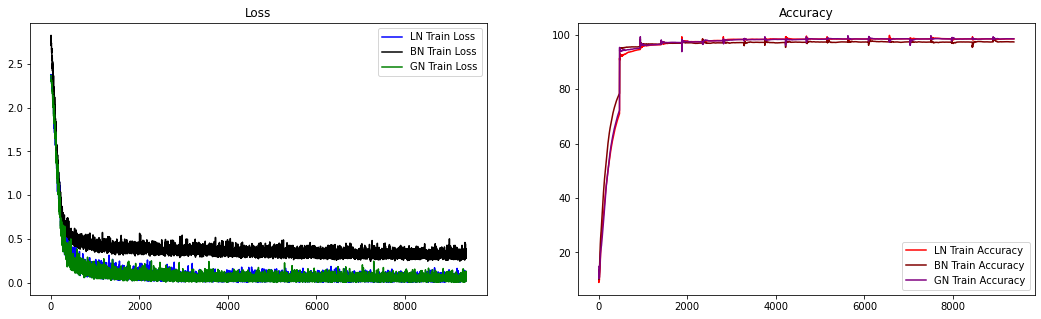

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
ax1 = ax[0]
ax1.set_title("Loss")
ax1.plot(l_train_losses, color="blue", label="LN Train Loss")
ax1.plot(b_train_losses, color="black", label="BN Train Loss")
ax1.plot(g_train_losses,color="green", label="GN Train Loss")
ax1.legend()
ax2 = ax[1]
ax2.set_title("Accuracy")
ax2.plot(l_train_acc, color="red", label="LN Train Accuracy")
ax2.plot(b_train_acc, color="maroon", label="BN Train Accuracy")
ax2.plot(g_train_acc, color="purple", label="GN Train Accuracy")
ax2.legend()

plt.show()